# Recognizing When the Instrument is Failing

There are times when [Sea-Bird Electronics, AC-S In-Situ Spectrophotometer](https://www.seabird.com/ac-s-spectral-absorption-and-attenuation-sensor/product?id=60762467715) deployed by OOI fails. It is hard to describe all the possible failure modes for such a complex instrument with multiple points of failure. The most common issue will be biofouling and determining how best to deal with that biofouling is really up to the researcher and their particular science question. OOI tries to mitigate biofouling, but the reality is the instrument was not designed with biofouling control in mind. These instruments will biofoul at some point during a deployment.

When biofouling starts and what exactly it looks like can be hard to determine at first. Other failure modes, however, are more readily apparent and usually indicate the end of useful data. For example, the internal temperature sensor could fail, lamps can burn out, the filter wheel shaft can start to loosen as it spins (results in light getting into detectors during a dark measurement affecting both channels), the instrument can flood, connectors can fail ... and the list goes on. 

Another point of failure has nothing to do with the AC-S: the data logger system can fail. If that happens, there just won't be any data. Not a failure of the AC-S per se, but still a data failure.

The data currently being collected (Deployment 9, 2022-07 to 2023-07) by the AC-S on the [Global Irminger Surface Mooring](https://oceanobservatories.org/site/gi01sumo/) 10 m instrument platform (Near-Surface Instrument Frame, NSIF) provides an example of two failure modes impacting the absorption and attenuations channels separately. So, let's go load that data set...

In [1]:
%matplotlib inline

# load the different libraries and modules needed for the analysis
import csv
import io
import numpy as np
import os
import pandas as pd
import re
import xarray as xr

from ooi_data_explorations.common import get_vocabulary, load_kdata
from ooi_data_explorations.uncabled.process_optaa import optaa_datalogger

from matplotlib import pyplot as plt

In [2]:
# Setup needed parameters for the request
site = 'GI01SUMO'           # OOI Net site designator
node = 'RID16'              # OOI Net node designator
sensor = '01-OPTAAD000'     # OOI Net sensor designator
stream = 'optaa_dj_dcl_instrument'  # OOI Net stream name
method = 'telemetered'      # OOI Net data delivery method
level = 'nsif'              # local directory name, level below site
instrmt = 'optaa'           # local directory name, instrument below level

# We are after the the data from deployment 9
vocab = get_vocabulary(site, node, sensor)[0]
deploy = 9

# set up the calibration file path and name
cal_path = os.path.join(os.path.expanduser('~'), 'acs_workshop/data/reprocess', site.lower(), level, instrmt)
cal_path = os.path.abspath(cal_path)
if not os.path.exists(cal_path):
    os.makedirs(cal_path)

cal_file = ('{}.{}.{}.deploy{:02d}.cal_coeffs.json'.format(site.lower(), level, instrmt, deploy))
cal_file = os.path.join(cal_path, cal_file)

In [3]:
%%time
# load data from the local kdata directory
optaa = load_kdata(site, node, sensor, method, stream, ('deployment%04d*OPTAA*.nc' % deploy))

Loading and Processing Data Files: 100%|██████████| 22/22 [00:20<00:00,  1.06it/s]
CPU times: user 18.6 s, sys: 11 s, total: 29.7 s
Wall time: 28 s


In [4]:
# view the dataset as downloaded from OOI (with some minor modifications, e.g. switching dimensions from obs to time)
optaa

<xarray.Dataset>
Dimensions:                       (time: 1254364, wavelength: 88)
Coordinates:
  * wavelength                    (wavelength) int32 0 1 2 3 4 ... 84 85 86 87
  * time                          (time) datetime64[ns] 2022-06-30T21:00:26 ....
Data variables: (12/21)
    external_temp_raw             (time) uint16 41486 41483 ... 40323 40323
    c_signal_counts               (time, wavelength) uint16 663 773 ... 3427
    a_signal_counts               (time, wavelength) uint16 678 809 ... 1614
    a_reference_counts            (time, wavelength) uint16 1355 1518 ... 6472
    wavelength_a                  (time, wavelength) float64 399.8 ... 739.1
    elapsed_run_time              (time) uint32 10322 10566 ... 228092 228342
    ...                            ...
    c_signal_dark_counts          (time) uint16 718 717 718 718 ... 718 718 718
    pressure_counts               (time) uint16 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    a_signal_dark_counts          (time) uint16 697 697 698 ... 11576 11522
    c_reference_counts            (time, wavelength) uint16 878 989 ... 8568
    a_reference_dark_counts       (time) uint16 465 465 465 466 ... 468 468 468
    sea_water_temperature         (time) float64 6.945 6.945 ... 8.858 8.858
Attributes: (12/69)
    node:                               RID16
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  telemetered
    stream:                             optaa_dj_dcl_instrument
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                59.936183
    lon:                                -39.470155

Let's apply the default processing module and then load in the co-located fluorometer data

In [5]:
%%time
# use the optaa_datalogger function for AC-S data from surface moorings
optaa = optaa_datalogger(optaa, cal_file)
optaa

Calculating burst averages ...
... burst averaging complete.  Elapsed time: 11.015189 seconds


Converting attenuation data ...: 100%|██████████| 1445/1445 [00:00<00:00, 5387.55it/s]


CPU times: user 12.9 s, sys: 1.05 s, total: 13.9 s
Wall time: 13.8 s


<xarray.Dataset>
Dimensions:                       (time: 1445, wavelength_number: 100)
Coordinates:
  * time                          (time) datetime64[ns] 2022-06-30T21:00:00 ....
  * wavelength_number             (wavelength_number) int64 0 1 2 3 ... 97 98 99
Data variables: (12/33)
    external_temp_raw             (time) int64 41482 41501 41435 ... 40551 40325
    elapsed_run_time              (time) float64 1.367e+05 ... 1.367e+05
    internal_temp_raw             (time) int64 51569 51578 51549 ... 51082 50955
    c_reference_dark              (time) int64 481 481 483 483 ... 481 483 481
    sea_water_practical_salinity  (time) float64 34.77 34.77 ... 34.79 34.79
    deployment                    (time) int64 9 9 9 9 9 9 9 9 ... 9 9 9 9 9 9 9
    ...                            ...
    wavelength_c                  (time, wavelength_number) float64 399.6 ......
    c_signal                      (time, wavelength_number) int64 649 ... -99...
    c_reference                   (time, wavelength_number) int64 861 ... -99...
    beam_attenuation              (time, wavelength_number) float64 nan ... nan
    cpg                           (time, wavelength_number) float64 0.3459 .....
    cpg_ts                        (time, wavelength_number) float64 nan ... nan
Attributes: (12/69)
    node:                               RID16
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  telemetered
    stream:                             optaa_dj_dcl_instrument
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                59.936183
    lon:                                -39.470155

In [6]:
%%time
from ooi_data_explorations.uncabled.process_flort import flort_datalogger

# Setup needed parameters for the request
sensor = '02-FLORTD000'     # OOI Net sensor designator
stream = 'flort_sample'     # OOI Net stream name
method = 'telemetered'      # OOI Net data delivery method
level = 'nsif'              # local directory name, level below site
instrmt = 'flort'           # local directory name, instrument below level

# load data from the local kdata directory
flort = load_kdata(site, node, sensor, method, stream, ('*deployment%04d*FLORT*.nc' % deploy))
flort = flort_datalogger(flort, burst=True)

# create an estimate of POC from the particulate backscatter data
flort['estimated_poc'] = 53607 * (flort['bback'] - flort['sea_water_scattering_coefficient']) + 2.5  # derived from Cetinic et al., 2012 and references there in

Loading and Processing Data Files: 100%|██████████| 269/269 [01:14<00:00,  3.59it/s]
CPU times: user 2min 42s, sys: 29.5 s, total: 3min 11s
Wall time: 2min 55s


As with the other examples, let's first look at the temperature sensors and then the estimates of chlorophyll and POC

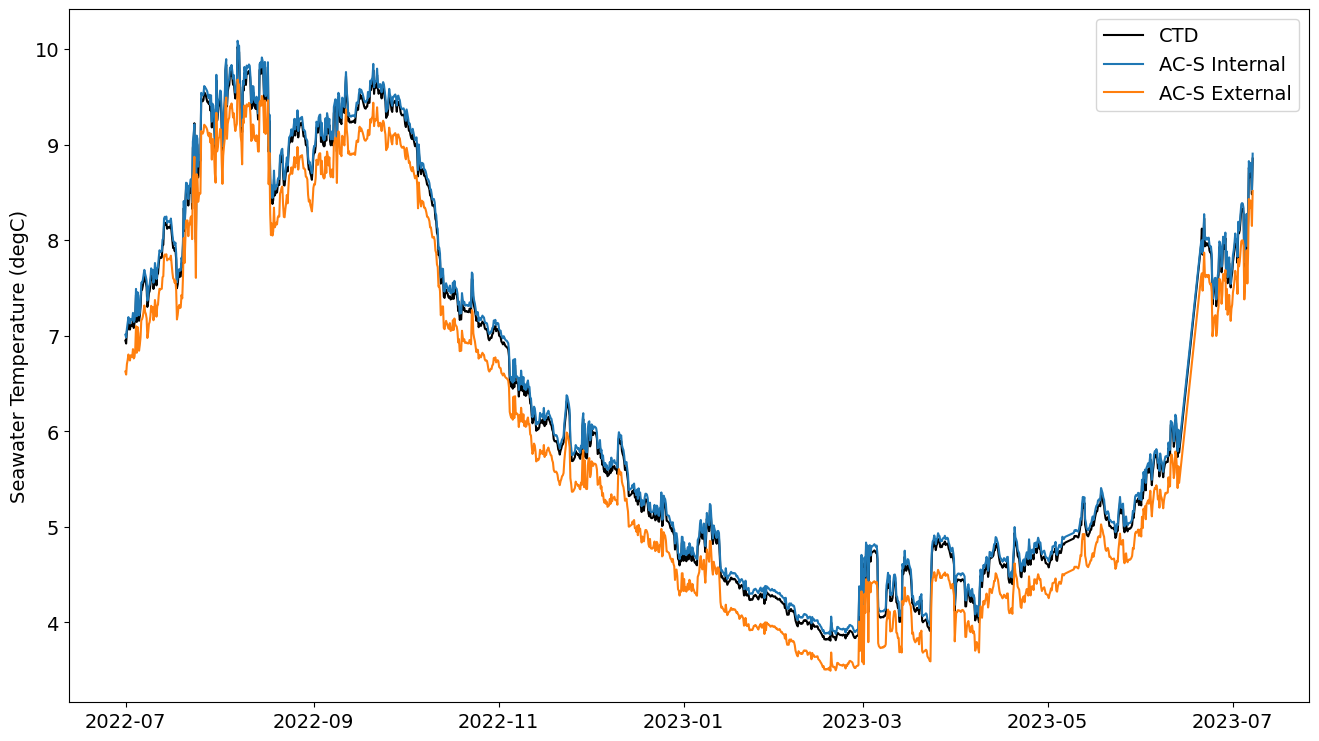

In [7]:
%matplotlib inline

# Plot the instrument and co-located CTD temperature records
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,9))
plt.plot(optaa['time'], optaa['sea_water_temperature'], '-k', label='CTD')
plt.plot(optaa['time'], optaa['internal_temp'], label='AC-S Internal')
plt.plot(optaa['time'], optaa['external_temp'], label='AC-S External')
plt.ylabel('Seawater Temperature (degC)')
plt.legend()

Again, we see really good agreement between the three sensors, although there is an offset between the CTD and the AC-S external temperature sensor (could most likely determine an offset and drift correction factor to better align the two temperature sensors). Now let's look at the AC-S data alongside the fluorometer data.

In [8]:
# show the FLORT dataset
flort

<xarray.Dataset>
Dimensions:                                (time: 33688, stats: 3)
Coordinates:
  * time                                   (time) datetime64[ns] 2022-06-30T1...
  * stats                                  (stats) int32 0 1 2
Data variables: (12/28)
    estimated_chlorophyll_qc_results       (time) float64 29.0 29.0 ... 29.0
    fluorometric_cdom                      (time) float64 0.453 0.453 ... 0.5436
    fluorometric_cdom_qc_executed          (time) float64 29.0 29.0 ... 29.0
    beta_700_qc_executed                   (time) float64 29.0 29.0 ... 29.0
    raw_fluorometric_cdom                  (time) float64 55.0 55.0 ... 56.0
    bback                                  (time) float64 0.004249 ... 0.003144
    ...                                     ...
    beta_700_qc_summary_flag               (time) float64 1.0 1.0 ... 3.0 1.0
    fluorometric_cdom_qc_summary_flag      (time) float64 1.0 1.0 ... 1.0 1.0
    fluorometric_cdom_burst_stats          (time, stats) float64 -0.0906 ... ...
    estimated_chlorophyll_burst_stats      (time, stats) float64 0.7568 ... 0...
    beta_700_burst_stats                   (time, stats) float64 0.0004222 .....
    estimated_poc                          (time) float64 195.7 196.4 ... 136.7
Attributes: (12/69)
    node:                               RID16
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  telemetered
    stream:                             flort_sample
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                59.936183
    lon:                                -39.470155

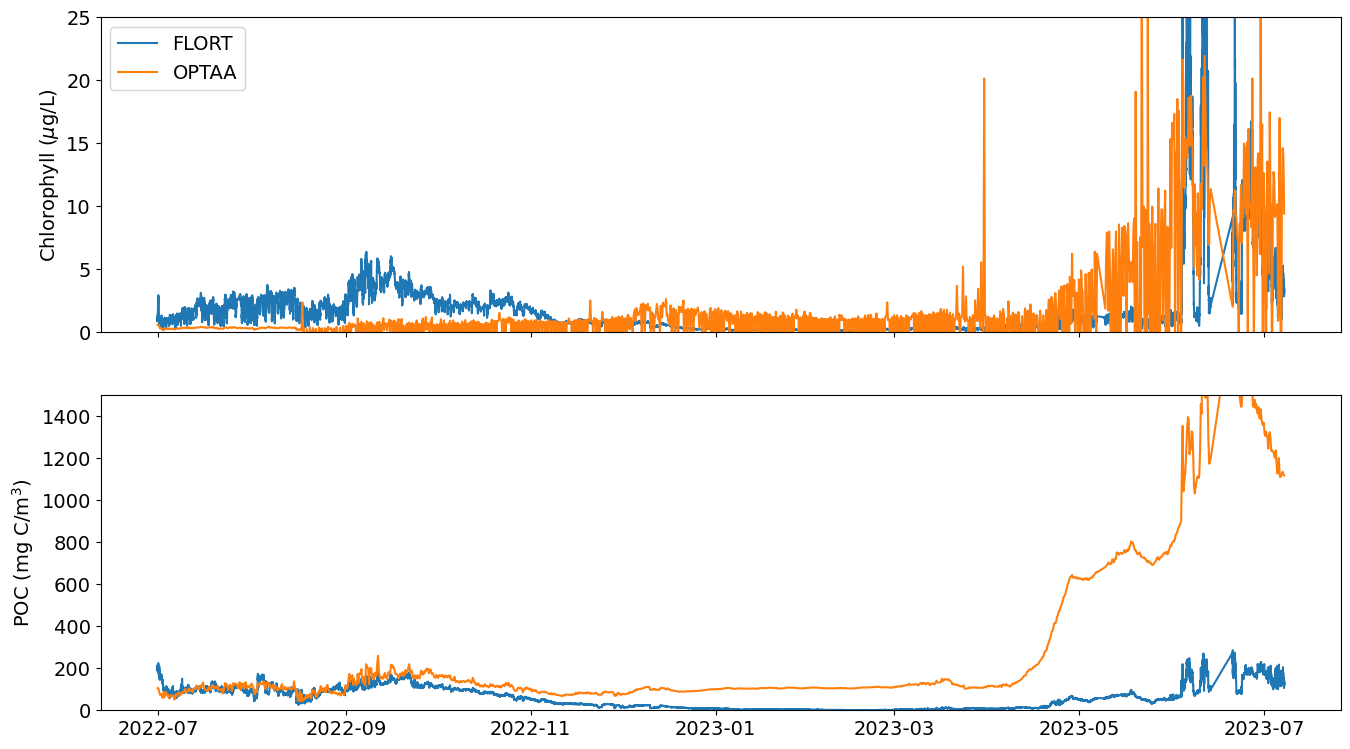

In [9]:
# plot the estimated chlorophyll and POC concentrations
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,9))

ax1 = plt.subplot(211)
plt.plot(flort['time'], flort['estimated_chlorophyll'], label='FLORT')
plt.plot(optaa['time'], optaa['estimated_chlorophyll'], label='OPTAA')
plt.ylabel('Chlorophyll ($\mu$g/L)')
plt.setp(ax1.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.ylim([0, 25])
plt.legend(loc='upper left')

ax2 = plt.subplot(212, sharex=ax1)
plt.plot(flort['time'], flort['estimated_poc'])
plt.plot(optaa['time'], optaa['estimated_poc'])
plt.ylabel('POC (mg C/m$^3$)')
plt.ylim([0, 1500])
plt.show()

Things are not looking so good, and we can see two different issues with the data. The POC data is indicative of biofouling. We see good agreement over the first ~2.5
months of the deployment and then we start to see a slowly increasing offset through the winter months. Most likely this form of biofouling represents a biofilm developing on the optics, slowly increasing in thickness. Come the spring when things heat up again, the biofouling takes off. A different way of seeing this is by looking at subselected values from the attenuation spectra...

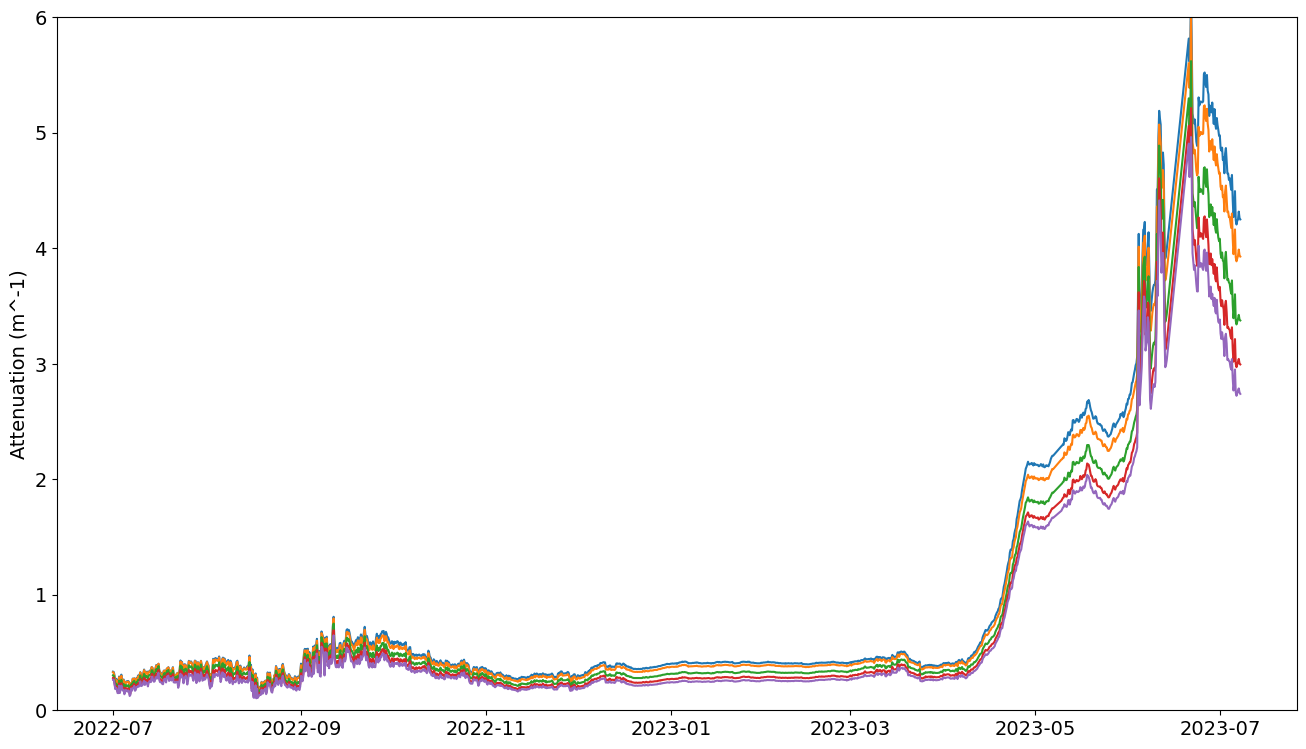

In [10]:
# plot the 5 select wavelengths from the attenuation spectra
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,9))

indices = [10, 20, 40, 60, 80]
plt.plot(optaa['time'], optaa['cpg_ts'][:, indices])
plt.ylabel('Attenuation (m^-1)')
plt.ylim([0, 6])
plt.show()

The attenuation values starting in April of 2023 are simply unreasonable. I would not expect to see values that high. One way to confirm this would be to look at the data from the soon to be deployed replacement mooring. If there is a large step-function between the two deployments, we are can be pretty confident we are looking at biofouling.

The absorption data is showing a different issue. Here is a case where looking at the raw data might help us understand what is happening. Five different variables go into converting the raw values to absorption or attenuation. These are dark measurements of the signal and reference channels, light measurements of the same channels, and the internal temperature sensor. Plotting these different measurements can help us identify potential instrument failures.

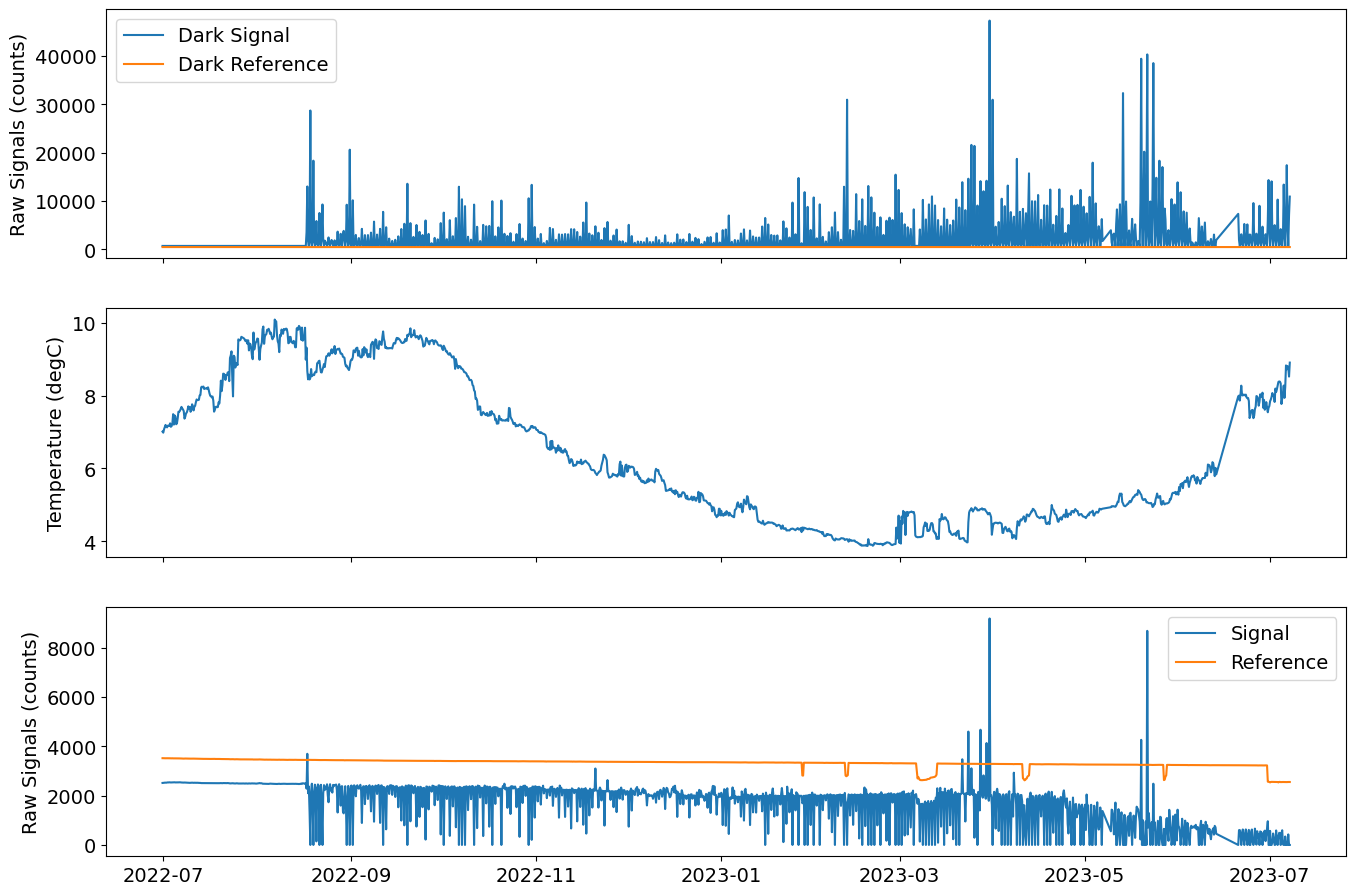

In [11]:
# plot the pigment ratios
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,11))

ax1 = plt.subplot(311)
plt.plot(optaa['time'], optaa['a_signal_dark'], label="Dark Signal")
plt.plot(optaa['time'], optaa['a_reference_dark'], label="Dark Reference")
plt.ylabel('Raw Signals (counts)')
plt.setp(ax1.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.legend()

ax2 = plt.subplot(312, sharex=ax1)
plt.plot(optaa['time'], optaa['internal_temp'])
plt.ylabel('Temperature (degC)')
plt.setp(ax2.get_xticklabels(), visible=False) # turn off x-axis ticklabels

ax3 = plt.subplot(313, sharex=ax1)
plt.plot(optaa['time'], optaa['a_signal'][:, 10], label='Signal')
plt.plot(optaa['time'], optaa['a_reference'][:, 10], label='Reference')
plt.ylabel('Raw Signals (counts)')
plt.legend()

plt.show()

And there is our failure. The dark signal measurements have turned into a field of grass when they should be a flat line. Somehow light is leaking into the system corrupting the dark measurement. If that measurement is incorrect, the derived absorption is incorrect and all bets are off. After the failure, the absorption data is unusable. The fact that the attenuation data doesn't show the same failure, suggests the absorption flow cell might have been knocked loose, allowing ambient light into the detectors.